<a href="https://colab.research.google.com/github/brunopdrocha/ibmec_computer_vision/blob/main/Ac6_ComputerVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

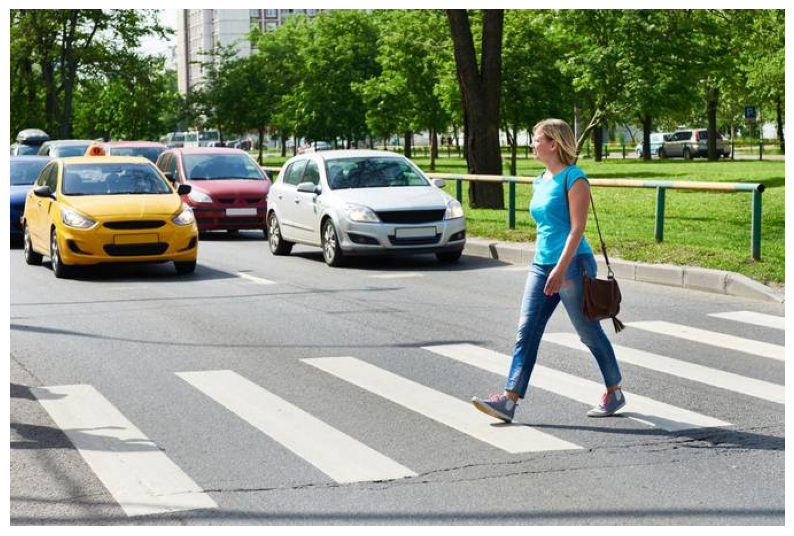

In [11]:
!pip install -q ultralytics

import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models, transforms
from ultralytics import YOLO
import time
import pandas as pd

image = cv2.imread('/content/fotopedestre.jpeg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


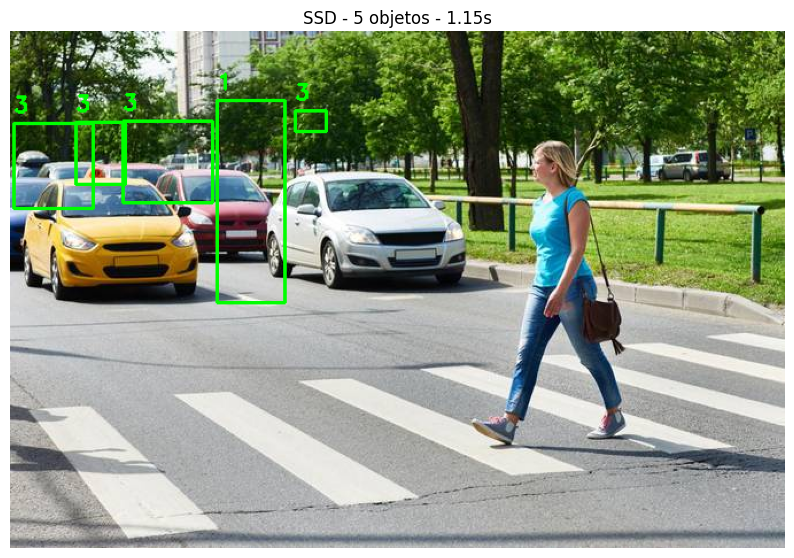

In [12]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])
input_tensor = transform(image_rgb).unsqueeze(0)
model_ssd = models.detection.ssd300_vgg16(pretrained=True).eval()

start_time = time.time()
with torch.no_grad():
    output_ssd = model_ssd(input_tensor)[0]
ssd_time = time.time() - start_time

threshold = 0.3  # ajustado para melhorar a sensibilidade
boxes_ssd = output_ssd['boxes'][output_ssd['scores'] > threshold].numpy()
labels_ssd = output_ssd['labels'][output_ssd['scores'] > threshold]

img_ssd = image_rgb.copy()
for box, label in zip(boxes_ssd, labels_ssd):
    x1, y1, x2, y2 = box.astype(int)
    cv2.rectangle(img_ssd, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_ssd, str(label.item()), (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

plt.figure(figsize=(10, 8))
plt.imshow(img_ssd)
plt.title(f"SSD - {len(boxes_ssd)} objetos - {ssd_time:.2f}s")
plt.axis('off')
plt.show()


PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


image 1/1 /content/fotopedestre.jpeg: 448x640 1 person, 5 cars, 1 truck, 1 handbag, 1115.0ms
Speed: 13.1ms preprocess, 1115.0ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


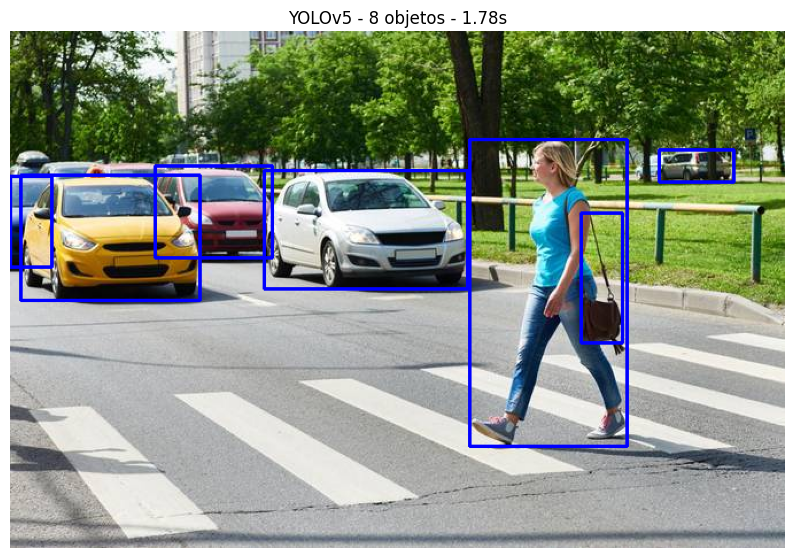

In [13]:
model_yolo = YOLO('yolov5s.pt')

start_time = time.time()
results = model_yolo.predict('/content/fotopedestre.jpeg', conf=0.3, show=False)
yolo_time = time.time() - start_time

img_yolo = cv2.imread('/content/fotopedestre.jpeg')
for r in results:
    for box in r.boxes.xyxy:
        x1, y1, x2, y2 = map(int, box[:4])
        cv2.rectangle(img_yolo, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_yolo, cv2.COLOR_BGR2RGB))
plt.title(f"YOLOv5 - {len(results[0].boxes)} objetos - {yolo_time:.2f}s")
plt.axis('off')
plt.show()


   Modelo  Tempo (s)  Objetos Detectados
0     SSD       1.15                   5
1  YOLOv5       1.78                   8


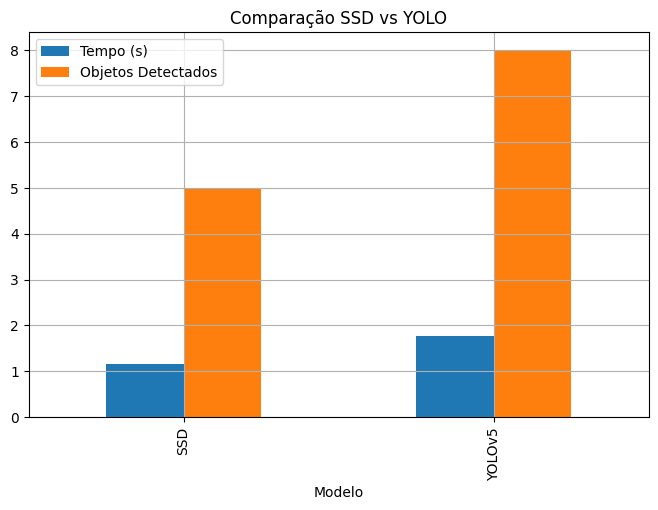

In [14]:
df = pd.DataFrame({
    'Modelo': ['SSD', 'YOLOv5'],
    'Tempo (s)': [round(ssd_time, 2), round(yolo_time, 2)],
    'Objetos Detectados': [len(boxes_ssd), len(results[0].boxes)]
})
print(df)

df.set_index('Modelo').plot(kind='bar', figsize=(8, 5), title='Comparação SSD vs YOLO')
plt.grid()
plt.show()
